In [45]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Autoencoder:

In [46]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [47]:
valid_size = 0.2
batch_size = 64
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = 0)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = 0)

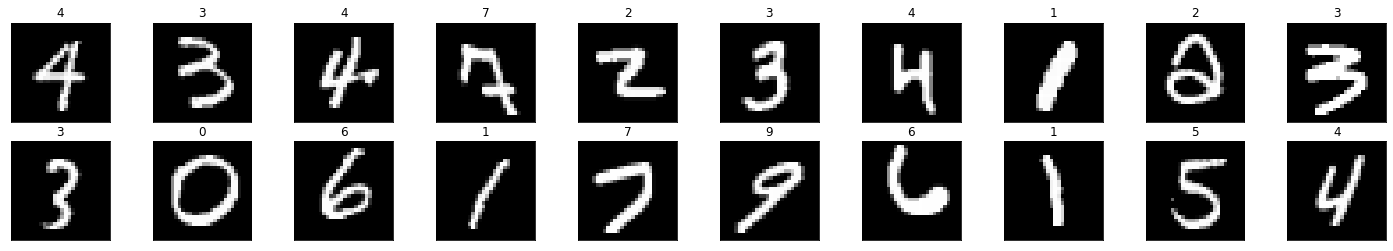

In [48]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images_np = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images_np[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

In [128]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = torch.nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
        )
        self.decoder = nn.Sequential(
           nn.Linear(128, 28*28),
           nn.Sigmoid(),      
        )

    def forward(self, x):
        x = self.flatten(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [129]:
torch.manual_seed(1)
flatten = torch.nn.Flatten()
model = NeuralNetwork()
print(model)
lossfunc = nn.MSELoss()
loss = lossfunc(model(images), flatten(images))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to('cpu')
print(loss.item())

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
    (1): Sigmoid()
  )
)
1.9060481786727905


In [130]:
n_epochs = 50
valid_loss_min = np.Inf
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    model.train()
    for data, label in train_loader:
        data = data.to('cpu')
        label = label.to('cpu')
        optimizer.zero_grad()
        generation = model(data)
        loss = lossfunc(generation, flatten(data))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    for data,label in valid_loader:
        data = data.to('cpu')
        label = label.to('cpu')
        output = model(data)
        loss = lossfunc(output, flatten(data))
        valid_loss += loss.item()

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    if epoch % 5 == 0 and epoch != 0:
        cont = input("Do you want to continue y/n")
        if cont == 'n':
            break
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.014542 	Validation Loss: 0.014438
Validation loss decreased (inf --> 0.014438).  Saving model ...
Epoch: 2 	Training Loss: 0.014370 	Validation Loss: 0.014362
Validation loss decreased (0.014438 --> 0.014362).  Saving model ...
Epoch: 3 	Training Loss: 0.014144 	Validation Loss: 0.013662
Validation loss decreased (0.014362 --> 0.013662).  Saving model ...
Epoch: 4 	Training Loss: 0.013347 	Validation Loss: 0.013275
Validation loss decreased (0.013662 --> 0.013275).  Saving model ...
Epoch: 5 	Training Loss: 0.013208 	Validation Loss: 0.013216
Validation loss decreased (0.013275 --> 0.013216).  Saving model ...
Epoch: 6 	Training Loss: 0.013169 	Validation Loss: 0.013189
Do you want to continue y/nn


In [131]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

(64, 28, 28)


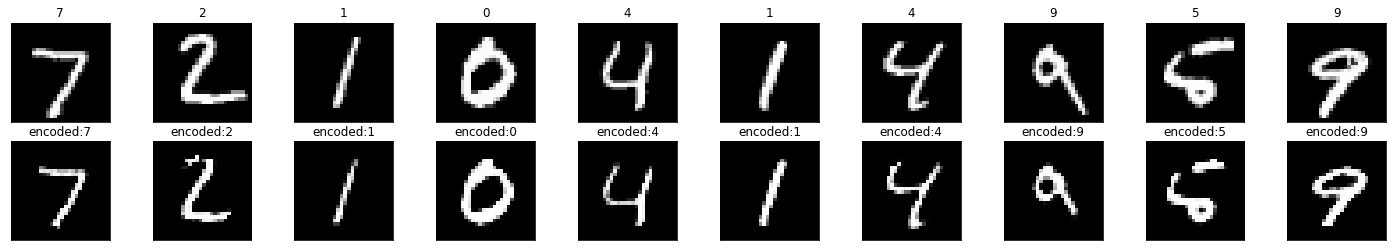

In [133]:
model.eval()
dataiter = iter(test_loader)
data, labels = dataiter.next()
output = model(data)
original_images = data.numpy()
encoder_images = output.reshape(-1, 28, 28).detach().numpy()
fig = plt.figure(figsize=(25, 4))
print(encoder_images.shape)
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(original_images[idx]), cmap='gray')
    ay = fig.add_subplot(2, 20//2, idx+11, xticks=[], yticks=[])
    ay.imshow(np.squeeze(encoder_images[idx]), cmap='gray')
    ax.set_title(labels[idx].item())
    ay.set_title("encoded:{}".format(labels[idx].item()))

# Variational Automencoder

In [147]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 20)
        self.fc3 = nn.Linear(256, 20)
        self.fc4 = nn.Linear(20, 256)
        self.fc5 = nn.Linear(256, 28*28)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = F.relu(self.fc2(x))
        log_var = F.relu(self.fc3(x))
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        x = mu + eps * std
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x, mu, log_var

In [148]:
vae_model = VAE()
print(vae_model)
optimizer_vae = torch.optim.Adam(vae_model.parameters(), lr=0.001)

VAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
  (fc3): Linear(in_features=256, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=784, bias=True)
)


In [159]:
n_epochs = 50
valid_loss_min = np.Inf
train_losses = []
valid_losses = []
for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    vae_model.train()
    for data, label in train_loader:
        data = data.to('cpu')
        label = label.to('cpu')
        optimizer_vae.zero_grad()
        generation, mu, log_var = vae_model(data)
        re_loss = F.binary_cross_entropy(generation, data.reshape(generation.shape), size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = re_loss + kl_div
        loss.backward()
        optimizer_vae.step()
        train_loss += loss.item()
        
    vae_model.eval()
    for data,label in valid_loader:
        data = data.to('cpu')
        label = label.to('cpu')
        output, mu, log_var = vae_model(data)
        re_loss = F.binary_cross_entropy(output, data.reshape(output.shape), size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = re_loss + kl_div
        valid_loss += loss.item()

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    if epoch % 5 == 0 and epoch != 0:
        cont = input("Do you want to continue y/n")
        if cont == 'n':
            break
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vae_model.state_dict(), 'vae_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: -58452.367271 	Validation Loss: -58203.546698
Validation loss decreased (inf --> -58203.546698).  Saving model ...
Epoch: 2 	Training Loss: -58530.856797 	Validation Loss: -58664.135792
Validation loss decreased (-58203.546698 --> -58664.135792).  Saving model ...
Epoch: 3 	Training Loss: -58916.147667 	Validation Loss: -59018.390354
Validation loss decreased (-58664.135792 --> -59018.390354).  Saving model ...
Epoch: 4 	Training Loss: -58986.054646 	Validation Loss: -59041.152594
Validation loss decreased (-59018.390354 --> -59041.152594).  Saving model ...
Epoch: 5 	Training Loss: -59052.056187 	Validation Loss: -59086.109750
Validation loss decreased (-59041.152594 --> -59086.109750).  Saving model ...
Epoch: 6 	Training Loss: -59126.276828 	Validation Loss: -59258.378396
Do you want to continue y/ny
Validation loss decreased (-59086.109750 --> -59258.378396).  Saving model ...
Epoch: 7 	Training Loss: -59151.700505 	Validation Loss: -59257.569583
Epoch: 8 	

In [160]:
vae_model.load_state_dict(torch.load('vae_model.pt'))

<All keys matched successfully>

(64, 28, 28)


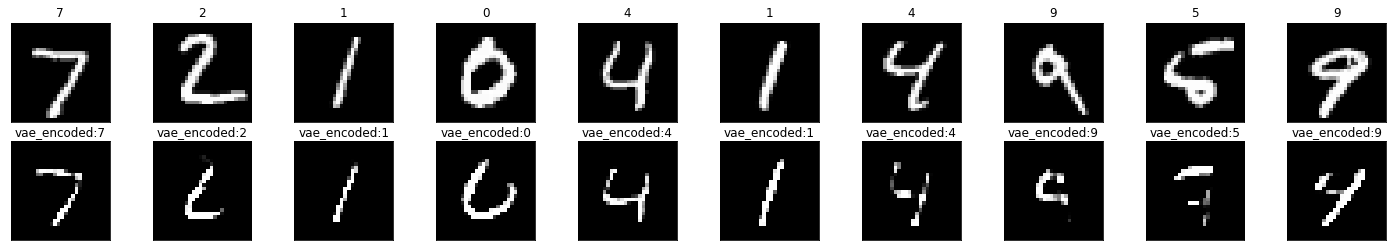

In [161]:
vae_model.eval()
dataiter = iter(test_loader)
data, labels = dataiter.next()
output, mu, log_var = vae_model(data)
original_images = data.numpy()
encoder_images = output.reshape(-1, 28, 28).detach().numpy()
fig = plt.figure(figsize=(25, 4))
print(encoder_images.shape)
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(original_images[idx]), cmap='gray')
    ay = fig.add_subplot(2, 20//2, idx+11, xticks=[], yticks=[])
    ay.imshow(np.squeeze(encoder_images[idx]), cmap='gray')
    ax.set_title(labels[idx].item())
    ay.set_title("vae_encoded:{}".format(labels[idx].item()))

From the model we can see that VAE is more feasible than AE. It can encode the picture with fewer features. And AE is a data-dependent encoder. So AE can only encode the data, that is similar with the training data. On the contrary, VAE is tend to generate data. Once we trained the decoder, we can use it to decode the data, that was generate by the Gaussian.